Nous traçons l'erreur RMSE en fonction de la taille du trou pour les méthodes d'interpolation linéaire, spline, LSTM bidirectionnel, LSTM bidirectionnel avec une station proche, et LSTM bidirectionnel avec trois stations proches. Pour chaque méthode, nous représentons la courbe correspondante.

In [12]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Bidirectional, Concatenate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimpy import *
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.interpolate import CubicSpline
from tensorflow.keras.callbacks import EarlyStopping
from math import radians, sin, cos, sqrt, atan2

num_stations=3
data = pd.read_csv("meteofrance.csv", sep = ";")
ss = np.unique(data['NUM_POSTE'].values)
colonnes_a_garder = ['AAAAMMJJHH',  ' T', 'NUM_POSTE', 'LAT', 'LON']
df = data.loc[:,colonnes_a_garder].copy()  # Création d'une copie
df.loc[:, 'AAAAMMJJHH'] = pd.to_datetime(df['AAAAMMJJHH'], format='%Y%m%d%H')
df.rename(columns={
    'AAAAMMJJHH' : 'date',
    ' T': 'temperature'
}, inplace=True)
df1 = df.loc[df['NUM_POSTE'] == 20004002]

start_column = 7
max_hole=6
N=10
tab_hole=[1,2,3,4,5,6]
column='temperature'

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Rayon de la Terre en kilomètres
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

main_station = df.loc[df['NUM_POSTE'] == 20004002].copy()
unique_stations = df.drop_duplicates(subset=['NUM_POSTE'])
lat1, lon1 = main_station['LAT'].values[0], main_station['LON'].values[0]
unique_stations['distance'] = unique_stations.apply(lambda row: haversine(lat1, lon1, row['LAT'], row['LON']), axis=1)
neighbor_stations = unique_stations[unique_stations['NUM_POSTE'] != 20004002].sort_values('distance').head(num_stations)
neighbor_stations = np.unique(neighbor_stations['NUM_POSTE'].values)
#print(neighbor_stations)
i=1
for station in neighbor_stations:
    station_data = df.loc[df['NUM_POSTE'] == station, ['date', 'temperature']].rename(columns={'temperature': f'temperature_station{i}'})
    i=i+1
    df1 = df1.merge(station_data, on='date', how='left')
    
combined_temps = np.concatenate([df1['temperature'].values] + [df1[f'temperature_station{j}'].values for j in range(1, i)])
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(combined_temps.reshape(-1, 1))

df1['temperature_scaled'] = scaler.transform(df1[['temperature']])
for j in range(1, i):
    df1[f'temperature_scaled{j}'] = scaler.transform(df1[[f'temperature_station{j}']])
rows_with_nan = df1[df1.isna().any(axis=1)].index.tolist()
rows_with_nan.insert(0, -1)
rows_with_nan.append(len(df1))

In [2]:
#interpolation lineaire
linear_rmse=[]


def create_gap(df, start_gap, gap_size, column):
    end_gap = start_gap + gap_size
    for i in range(start_gap, end_gap):
        df.at[i, column] = np.nan
    return df
    
column = "temperature"
for i in range(1, max_hole + 1):
    gap_size= i
    sum=0
    l=0
    for j in range(len(rows_with_nan) - 1):
        start_index= rows_with_nan[j] + 1
        end_index= rows_with_nan[j + 1] - 1
        df_sampled=df1[start_index:end_index + 1]
        df_sampled = df_sampled.reset_index(drop=True)
        for k in range(N, len(df_sampled) + 1 - gap_size - N):
            start_gap = k
            df_gapped = create_gap(df_sampled.copy(), start_gap, gap_size, column)
            df_gapped=df_gapped.iloc[k - N:k + gap_size + N ]
            df_interpolated = df_gapped.interpolate(method='linear')
            diff = (df_sampled.iloc[k - N: k+ gap_size + N]['temperature'] - df_interpolated['temperature']) **2
            sum+= diff.sum()
            l+=gap_size
    linear_rmse.append(np.sqrt(sum/l))
print(linear_rmse)

[0.6021863012155847, 0.7997504971590749, 1.0106561239879388, 1.2245172754568026, 1.4444951417901502, 1.6720840707931819]


In [3]:
#spline cubique
spline_rmse=[]

def create_gap(df, start_gap, gap_size, column):
    end_gap = start_gap + gap_size
    for i in range(start_gap, end_gap):
        df.at[i, column] = np.nan
    return df
    
for i in range(1, max_hole + 1):
    gap_size= i
    sum=0
    l=0
    for j in range(len(rows_with_nan) - 1):
        start_index= rows_with_nan[j] + 1
        end_index= rows_with_nan[j + 1] - 1
        df_sampled=df1[start_index:end_index + 1]
        df_sampled['timestamp'] = df1['date'].astype(np.int64) // 10**9
        df_sampled = df_sampled.reset_index(drop=True)
        for k in range(N, len(df_sampled) +1 - gap_size - N):
            start_gap = k
            df_gapped = create_gap(df_sampled.copy(), start_gap, gap_size, column)
            df_gapped=df_gapped.iloc[k - N:k + gap_size + N ]
            known_data = df_gapped.dropna(subset=['temperature'])
            missing_data = df_gapped[df_gapped['temperature'].isna()]
            x_known = known_data['timestamp'].values
            y_known = known_data['temperature'].values
            cs = CubicSpline(x_known, y_known, bc_type='natural')
            x_missing = missing_data['timestamp'].values
            y_missing_interpolated = cs(x_missing)
            df_gapped.loc[df_gapped['temperature'].isna(), 'temperature'] = y_missing_interpolated
            diff = (df_sampled.iloc[k - N: k+ gap_size + N]['temperature'] - df_gapped['temperature']) **2
            sum+= diff.sum()
            l+=gap_size
    spline_rmse.append(np.sqrt(sum/l))
print(spline_rmse)

[0.587030943976108, 0.7595265651832689, 0.9634103601048116, 1.166982333562849, 1.3764877144873955, 1.5711094441369076]


In [4]:
#lstm

lstm_rmse=[]
models=[]
X_tests=[]
y_tests=[]
X=np.array([])
y=np.array([])
predictions=[]


def create_sequences(data, input_steps, output_steps, future_steps, rows_with_nan):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps - future_steps + 1):
        if any(idx in rows_with_nan for idx in range(i, i + input_steps + output_steps + future_steps)):
            continue
        past_seq = data[i:i + input_steps].values
        future_seq = data[i + input_steps + output_steps:i + input_steps + output_steps + future_steps].values
        target_seq = data[i + input_steps:i + input_steps + output_steps].values
        X.append(np.concatenate((past_seq, future_seq)))
        y.append(target_seq)
    return np.array(X), np.array(y)




def create_model(dense_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(16, activation='relu'), input_shape=(N * 2, 1)))
    model.add(Dense(dense_size))
    model.compile(optimizer='adam', loss='mse')
    return model


for i in range(6):
    model=create_model(i + 1)
    models.append(model)       
d=1
for model in models:
    for j in range(len(rows_with_nan) - 1):
        start_index= rows_with_nan[j] + 1
        end_index= rows_with_nan[j + 1] - 1 
        df_sampled=df1[start_index:end_index]
        df_sampled['temperature_scaled'] = scaler.fit_transform(df_sampled[['temperature']])
        df_sampled = df_sampled.reset_index(drop=True)
        Xi, yi = create_sequences(df_sampled['temperature_scaled'], N, d, N, rows_with_nan)
        if j==0:
            X= Xi
            y=yi
        else:
            X= np.concatenate((X,Xi))
            y=np.concatenate((y,yi))
    X = X.reshape((X.shape[0], X.shape[1], 1))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    history = model.fit(X_train, y_train, epochs=100, verbose=1)
    X_tests.append(X_test)
    y_tests.append(y_test)
    d+=1


for i in range(6):
    prediction_scaled = models[i].predict(X_tests[i])
    prediction=scaler.inverse_transform(prediction_scaled.reshape(-1,1))
    attendu=scaler.inverse_transform(y_tests[i])
    rmse = np.sqrt(mean_squared_error(prediction.flatten(), attendu.flatten()))
    lstm_rmse.append(rmse)
print(lstm_rmse)

Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0815
Epoch 2/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0026
Epoch 3/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0019
Epoch 4/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0016
Epoch 5/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0016
Epoch 6/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0014
Epoch 7/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0013
Epoch 8/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0012
Epoch 9/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0012
Epoch 10/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0011
Epoch 11/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0011
Epoch 12/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0010
Epoch 13/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.4725e-04
Epoch 14/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0010
Epoch 15/100
305/305 ━━━━━━━━━━━━━━━━━━

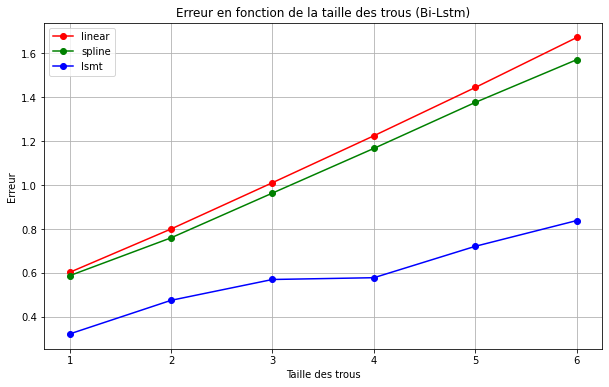

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(tab_hole, linear_rmse, marker='o', linestyle='-', color='r', label="linear")
plt.plot(tab_hole, spline_rmse, marker='o', linestyle='-', color='g', label="spline")
plt.plot(tab_hole, lstm_rmse, marker='o', linestyle='-', color='b', label="lsmt")
plt.title("Erreur en fonction de la taille des trous (Bi-Lstm)")
plt.xlabel("Taille des trous")
plt.ylabel("Erreur")
plt.grid(True)
plt.legend()
plt.show()

In [3]:
#lstm 1 station a proximite

lstm1s_rmse=[]
models=[]
X_tests=[]
y_tests=[]
X_lstm=np.array([])
X_temporel=np.array([])
X_nearby=np.array([])
y=np.array([])
predictions=[]



def create_sequences(df, input_steps, output_steps, future_steps, rows_with_nan):
    X_lstm, X_temporal, X_nearby, y = [], [], [], []
    for i in range(len(df) - input_steps - output_steps - future_steps + 1):
        if any(idx in rows_with_nan for idx in range(i, i + input_steps + output_steps + future_steps)):
            continue
        # Séquences de température pour LSTM
        past_seq = df['temperature_scaled'][i:i + input_steps].values
        future_seq = df['temperature_scaled'][i + input_steps + output_steps:i + input_steps + output_steps + future_steps].values
        target_seq = df['temperature_scaled'][i + input_steps:i + input_steps + output_steps].values

        # Données temporelles pour la première date de la séquence
        start_date = df['date'].iloc[i]
        day_cos = np.cos(start_date.dayofyear / 365.25 * 2 * np.pi)
        day_sin = np.sin(start_date.dayofyear / 365.25 * 2 * np.pi)
        hour_cos = np.cos(start_date.hour / 24.0 * 2 * np.pi)
        hour_sin = np.sin(start_date.hour / 24.0 * 2 * np.pi)
        temporal_data = np.array([day_cos, day_sin, hour_cos, hour_sin])

        # Données des températures des stations voisines
        station1_data = df['temperature_scaled1'][i + input_steps:i + input_steps + output_steps].values
        nearby_data = station1_data

        X_lstm.append(np.concatenate((past_seq, future_seq)))
        X_temporal.append(temporal_data)
        X_nearby.append(nearby_data)
        y.append(target_seq)

    return np.array(X_lstm), np.array(X_temporal), np.array(X_nearby), np.array(y)




def create_model(lstm_units, dense_size, additional_dense_size1, additional_dense_size2):
    # Input pour les données séquentielles de température
    lstm_input = Input(shape=(N * 2, 1))
    lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'))(lstm_input)
    
    # Input pour les données temporelles encodées
    temporal_input = Input(shape=(4,))  # Assumant 4 valeurs pour cos/sin jour et heure
    dense_temporal = Dense(additional_dense_size1, activation='relu')(temporal_input)
    
    # Input pour les températures des stations à proximité
    nearby_temp_input = Input(shape=(dense_size,))
    dense_nearby_temp = Dense(additional_dense_size2, activation='relu')(nearby_temp_input)
    
    # Concaténation des sorties
    concatenated = Concatenate()([lstm_out, dense_temporal, dense_nearby_temp])
    # Couche de sortie
    main_output = Dense(dense_size, activation='relu')(concatenated)
    # Création et compilation du modèle
    model = Model(inputs=[lstm_input, temporal_input, nearby_temp_input], outputs=main_output)
    model.compile(optimizer='adam', loss='mse')
    return model



for i in range(6):
    model=create_model(32,i + 1, 4, 2  * (i+1) )
    models.append(model)       
d=1
for model in models:
    for j in range(len(rows_with_nan) - 1):
        start_index= rows_with_nan[j] + 1
        end_index= rows_with_nan[j + 1] - 1 
        df_sampled=df1[start_index:end_index]
        df_sampled['temperature_scaled'] = scaler.fit_transform(df_sampled[['temperature']])
        df_sampled = df_sampled.reset_index(drop=True)
        Xi_lstm, Xi_temporal, Xi_nearby, yi = create_sequences(df_sampled, N, d, N, rows_with_nan)
        if j==0:
            X_lstm= Xi_lstm
            X_temporal=Xi_temporal
            X_nearby=Xi_nearby
            y=yi
        else:
            X_lstm= np.concatenate((X_lstm,Xi_lstm))
            X_temporal= np.concatenate((X_temporal,Xi_temporal))
            X_nearby= np.concatenate((X_nearby,Xi_nearby))
            y=np.concatenate((y,yi))
    X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))
    X_lstm_train, X_lstm_test, X_temporal_train, X_temporal_test, X_nearby_train, X_nearby_test, y_train, y_test = train_test_split(
    X_lstm, X_temporal, X_nearby, y, test_size=0.2, random_state=123)
    model.fit([X_lstm_train, X_temporal_train, X_nearby_train], y_train, epochs=100, verbose=1)
    X_tests.append([X_lstm_test, X_temporal_test, X_nearby_test])
    y_tests.append(y_test)
    d+=1

for i in range(6):
    prediction_scaled = models[i].predict(X_tests[i])
    prediction=scaler.inverse_transform(prediction_scaled.reshape(-1,1))
    attendu=scaler.inverse_transform(y_tests[i])
    rmse = np.sqrt(mean_squared_error(prediction.flatten(), attendu.flatten()))
    lstm1s_rmse.append(rmse)
print(lstm1s_rmse)

Epoch 1/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0842
Epoch 2/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0026
Epoch 3/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0019
Epoch 4/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0017
Epoch 5/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0015
Epoch 6/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0015
Epoch 7/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0012
Epoch 8/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0011
Epoch 9/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.9750e-04
Epoch 10/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.8176e-04
Epoch 11/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.3946e-04
Epoch 12/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.5887e-04
Epoch 13/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.5875e-04
Epoch 14/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.5647e-04
Epoch 15/100
302/30

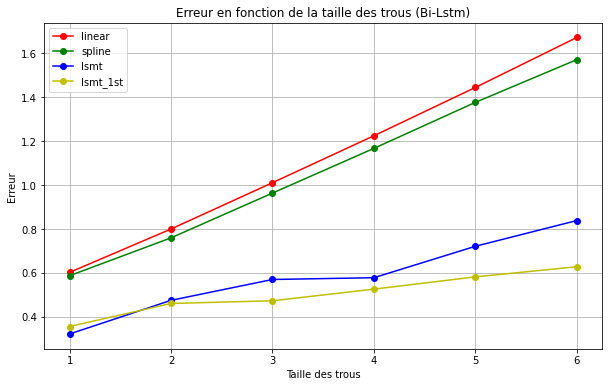

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(tab_hole, linear_rmse, marker='o', linestyle='-', color='r', label="linear")
plt.plot(tab_hole, spline_rmse, marker='o', linestyle='-', color='g', label="spline")
plt.plot(tab_hole, lstm_rmse, marker='o', linestyle='-', color='b', label="lsmt")
plt.plot(tab_hole, lstm1s_rmse, marker='o', linestyle='-', color='y', label="lsmt_1st")
plt.title("Erreur en fonction de la taille des trous (Bi-Lstm)")
plt.xlabel("Taille des trous")
plt.ylabel("Erreur")
plt.grid(True)
plt.legend()
plt.show()

In [6]:
#lstm 1 station a proximite

lstm3s_rmse=[]
models=[]
X_tests=[]
y_tests=[]
X_lstm=np.array([])
X_temporel=np.array([])
X_nearby=np.array([])
y=np.array([])
predictions=[]



def create_sequences(df, input_steps, output_steps, future_steps, rows_with_nan):
    X_lstm, X_temporal, X_nearby, y = [], [], [], []
    for i in range(len(df) - input_steps - output_steps - future_steps + 1):
        if any(idx in rows_with_nan for idx in range(i, i + input_steps + output_steps + future_steps)):
            continue
        # Séquences de température pour LSTM
        past_seq = df['temperature_scaled'][i:i + input_steps].values
        future_seq = df['temperature_scaled'][i + input_steps + output_steps:i + input_steps + output_steps + future_steps].values
        target_seq = df['temperature_scaled'][i + input_steps:i + input_steps + output_steps].values

        # Données temporelles pour la première date de la séquence
        start_date = df['date'].iloc[i]
        day_cos = np.cos(start_date.dayofyear / 365.25 * 2 * np.pi)
        day_sin = np.sin(start_date.dayofyear / 365.25 * 2 * np.pi)
        hour_cos = np.cos(start_date.hour / 24.0 * 2 * np.pi)
        hour_sin = np.sin(start_date.hour / 24.0 * 2 * np.pi)
        temporal_data = np.array([day_cos, day_sin, hour_cos, hour_sin])

        # Données des températures des stations voisines
        station1_data = df['temperature_scaled1'][i + input_steps:i + input_steps + output_steps].values
        station2_data = df['temperature_scaled2'][i + input_steps:i + input_steps + output_steps].values
        station3_data = df['temperature_scaled3'][i+ input_steps:i + input_steps + output_steps].values
        nearby_data = np.column_stack((station1_data, station2_data, station3_data)).flatten()

        X_lstm.append(np.concatenate((past_seq, future_seq)))
        X_temporal.append(temporal_data)
        X_nearby.append(nearby_data)
        y.append(target_seq)

    return np.array(X_lstm), np.array(X_temporal), np.array(X_nearby), np.array(y)




def create_model(lstm_units, dense_size, additional_dense_size1, additional_dense_size2):
    # Input pour les données séquentielles de température
    lstm_input = Input(shape=(N * 2, 1))
    lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'))(lstm_input)
    
    # Input pour les données temporelles encodées
    temporal_input = Input(shape=(4,))  # Assumant 4 valeurs pour cos/sin jour et heure
    dense_temporal = Dense(additional_dense_size1, activation='relu')(temporal_input)
    
    # Input pour les températures des stations à proximité
    nearby_temp_input = Input(shape=(3 * dense_size,))
    dense_nearby_temp = Dense(additional_dense_size2, activation='relu')(nearby_temp_input)
    
    # Concaténation des sorties
    concatenated = Concatenate()([lstm_out, dense_temporal, dense_nearby_temp])
    # Couche de sortie
    main_output = Dense(dense_size, activation='relu')(concatenated)
    # Création et compilation du modèle
    model = Model(inputs=[lstm_input, temporal_input, nearby_temp_input], outputs=main_output)
    model.compile(optimizer='adam', loss='mse')
    return model



for i in range(6):
    model=create_model(32,i + 1, 4, 2  * (i+1) )
    models.append(model)       
d=1
for model in models:
    for j in range(len(rows_with_nan) - 1):
        start_index= rows_with_nan[j] + 1
        end_index= rows_with_nan[j + 1] - 1 
        df_sampled=df1[start_index:end_index]
        df_sampled['temperature_scaled'] = scaler.fit_transform(df_sampled[['temperature']])
        df_sampled = df_sampled.reset_index(drop=True)
        Xi_lstm, Xi_temporal, Xi_nearby, yi = create_sequences(df_sampled, N, d, N, rows_with_nan)
        if j==0:
            X_lstm= Xi_lstm
            X_temporal=Xi_temporal
            X_nearby=Xi_nearby
            y=yi
        else:
            X_lstm= np.concatenate((X_lstm,Xi_lstm))
            X_temporal= np.concatenate((X_temporal,Xi_temporal))
            X_nearby= np.concatenate((X_nearby,Xi_nearby))
            y=np.concatenate((y,yi))
    X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))
    X_lstm_train, X_lstm_test, X_temporal_train, X_temporal_test, X_nearby_train, X_nearby_test, y_train, y_test = train_test_split(
    X_lstm, X_temporal, X_nearby, y, test_size=0.2, random_state=123)
    model.fit([X_lstm_train, X_temporal_train, X_nearby_train], y_train, epochs=100, verbose=1)
    X_tests.append([X_lstm_test, X_temporal_test, X_nearby_test])
    y_tests.append(y_test)
    d+=1

for i in range(6):
    prediction_scaled = models[i].predict(X_tests[i])
    prediction=scaler.inverse_transform(prediction_scaled.reshape(-1,1))
    attendu=scaler.inverse_transform(y_tests[i])
    rmse = np.sqrt(mean_squared_error(prediction.flatten(), attendu.flatten()))
    lstm3s_rmse.append(rmse)
print(lstm3s_rmse)

Epoch 1/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0562
Epoch 2/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0038
Epoch 3/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0024
Epoch 4/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0019
Epoch 5/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0017
Epoch 6/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0014
Epoch 7/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0013
Epoch 8/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0011
Epoch 9/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0011
Epoch 10/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0011
Epoch 11/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0010
Epoch 12/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.4148e-04
Epoch 13/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.7795e-04
Epoch 14/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.8411e-04
Epoch 15/100
302/302 ━━━━━━━━━━

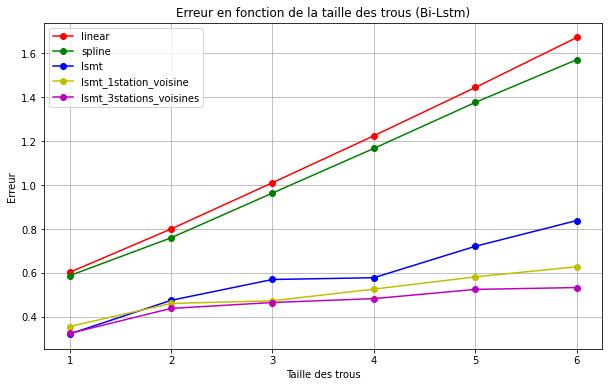

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(tab_hole, linear_rmse, marker='o', linestyle='-', color='r', label="linear")
plt.plot(tab_hole, spline_rmse, marker='o', linestyle='-', color='g', label="spline")
plt.plot(tab_hole, lstm_rmse, marker='o', linestyle='-', color='b', label="lsmt")
plt.plot(tab_hole, lstm1s_rmse, marker='o', linestyle='-', color='y', label="lsmt_1station_voisine")
plt.plot(tab_hole, lstm3s_rmse, marker='o', linestyle='-', color='m', label="lsmt_3stations_voisines")
plt.title("Erreur en fonction de la taille des trous (Bi-Lstm)")
plt.xlabel("Taille des trous")
plt.ylabel("Erreur")
plt.grid(True)
plt.legend()
plt.show()